In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from viz_utils import *

In [2]:
experiments, meta = load_results(base_dir="results/", dataset="IMDB", model="JWA")
samplers = list(experiments.keys())
df_tr, df_agr, df_crt = results_to_df(experiments, meta, mode="last")

In [3]:
df_crt

,,correctness,confidence,variability,forgetfulness,threshold_closeness
sampler,al_iter,,,,,
random,0,"[2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.5, 0.5, 2.0, ...","[0.70464057, 0.5960382, 0.5640834, 0.6716231, ...","[0.27930218, 0.12728131, 0.08395296, 0.2363622...","[0.0, 0.0, 0.0, 0.0, 1000.0, 0.0, 500.0, 500.0...","[0.20811763, 0.23866421, 0.24529251, 0.2205016..."


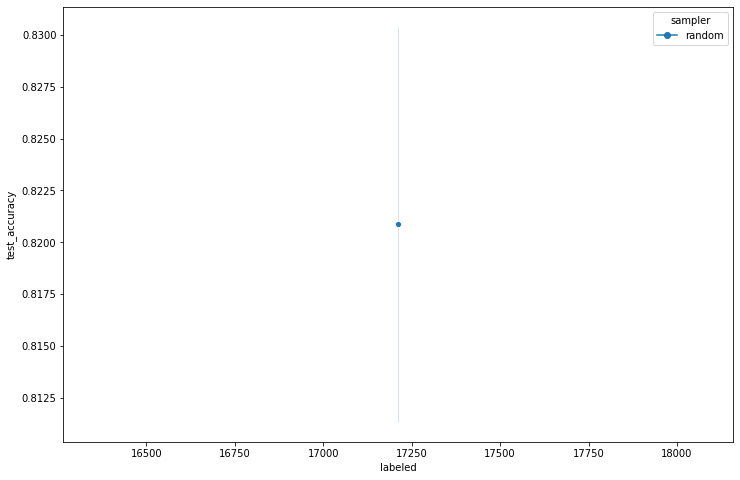

In [21]:
plot_al_accuracy(df_tr)

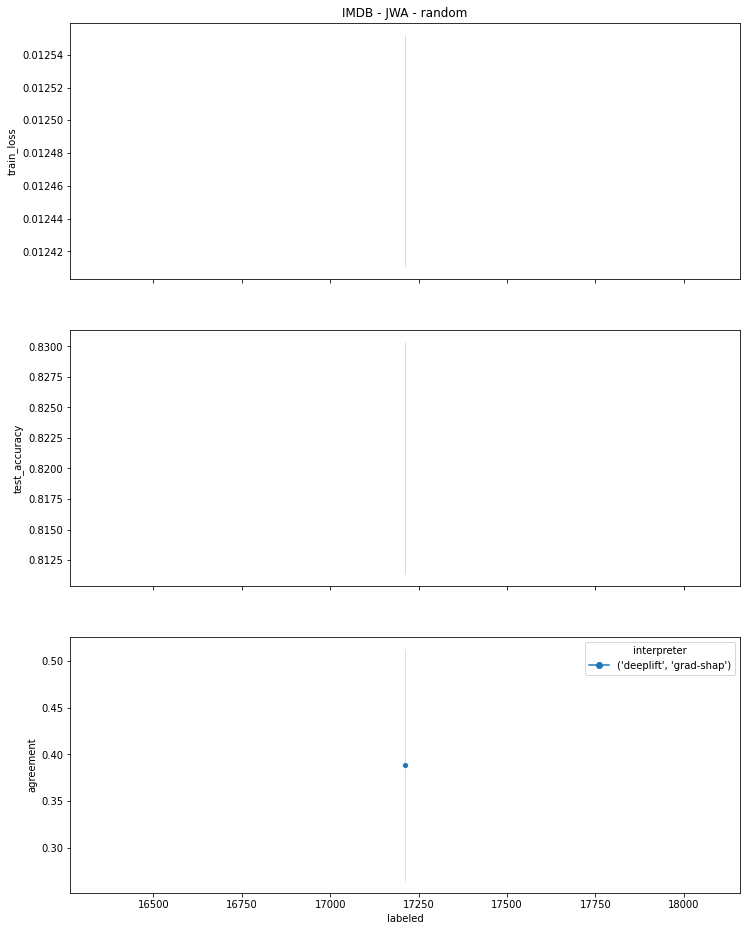

In [22]:
plot_experiment_set(df_tr, df_agr, meta, "random")

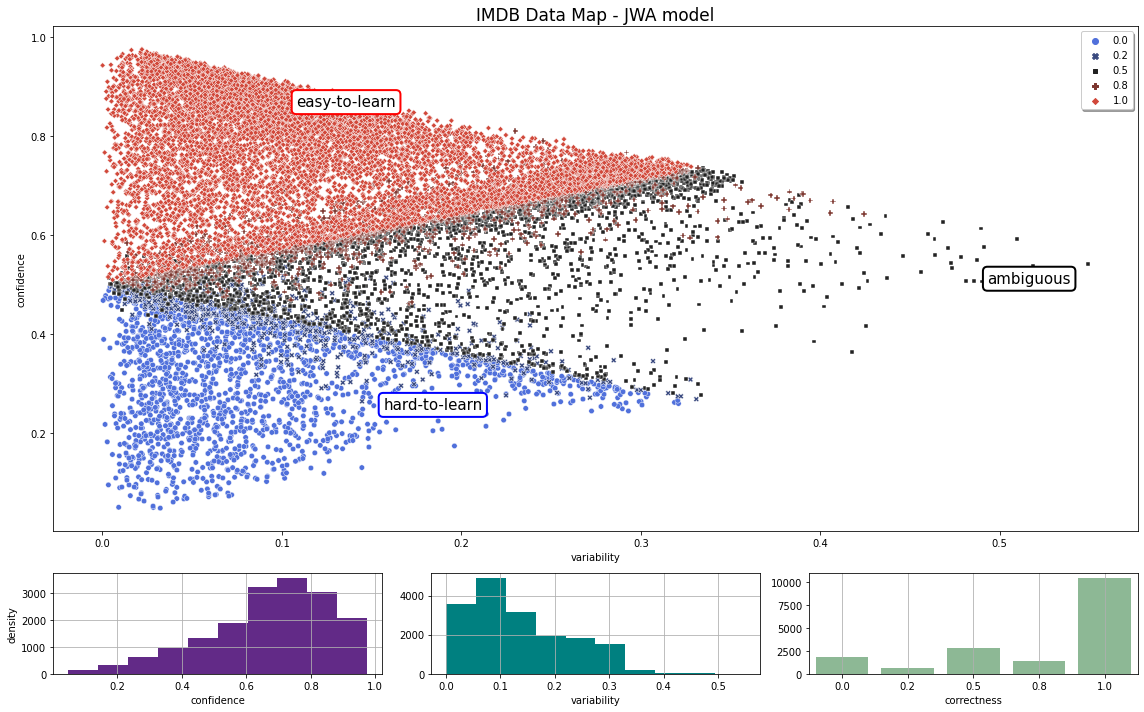

In [5]:
plot_cartography(df_crt, "random", 0, meta, hue_metric="correct")

In [24]:
def plot_last_epoch(experiment, interpret_pairs):
    agreement_dict = defaultdict(list)
    train_scores = []
    eval_scores = []
    for (al_epoch, (L, A, T, E)) in enumerate(
        zip(
            experiment["labeled"], experiment["agreement"], experiment["train"], experiment["eval"]
        ),
        1,
    ):
        for ip in interpret_pairs:
            agreement_dict[ip].append(list(A)[-1][ip])
        train_scores.append(list(T)[-1]["loss"])
        eval_scores.append(list(E)[-1]["accuracy"]/100)

    fig, axs = plt.subplots(3, figsize=(12, 10), sharex=True)
    axs[0].scatter(experiment["labeled"], train_scores, color="r")
    axs[0].plot(experiment["labeled"], train_scores, color="r")
    axs[0].set_ylabel("Loss")
    axs[1].scatter(experiment["labeled"], eval_scores, color="g")
    axs[1].plot(experiment["labeled"], eval_scores, color="g")
    axs[1].set_ylabel("Accuracy")
    for ip, agrs in agreement_dict.items():
        axs[2].scatter(experiment["labeled"], agrs)
        axs[2].plot(experiment["labeled"], agrs)
        
    axs[2].set_ylabel("Agreement")
    axs[2].set_xlabel("# labeled")
    axs[2].legend(interpret_pairs)


def plot_al_agreement(experiment_sets, meta, figsize=(12, 8), ci=90):
    fig, axs = plt.subplots(len(meta["interpret_pairs"]), figsize=figsize)
    if type(axs) is not list:
        axs = [axs]
    for ip, ax in zip(meta["interpret_pairs"], axs):
        dfs = []
        for exp_set, sampler in zip(experiment_sets, samplers):
            _, df_agr, _ = extract_last_epoch(exp_set, meta["interpret_pairs"])
            df_new = df_agr[df_agr.index.get_level_values("interpreter") == ip].copy()
            df_new["sampler"] = sampler
            dfs.append(df_new)

        agr_data = pd.concat(dfs)
        sns.lineplot(
            ax=ax,
            data=agr_data,
            x="labeled",
            y="agreement",
            hue="sampler",
            style="sampler",
            markers=True,
            dashes=False,
            picker=1,
            ci=ci,
        )
        ax.set_title(ip)
        
        
def plot_epochwise_trend(results, interpreter):
    agreements = []
    for (al_epoch, (L, A, T, E)) in enumerate(
        zip(
            results["labeled"], results["agreement"], results["train"], results["eval"]
        ),
        1,
    ):

        for a in A:
            agreement = a[interpreter]
            if np.isnan(agreement):
                agreement = 0
            agreements.append(agreement)

    plt.figure(figsize=(20, 8))
    plt.scatter(range(len(agreements)), agreements)
    plt.plot(range(len(agreements)), agreements)
    plt.vlines(
        range(len(A), len(results["labeled"]) * len(A), len(A)),
        ymin=-0.2,
        ymax=1,
        color="r",
    )
    plt.ylabel("Agreeement")
    plt.title(interpreter)